# Importing Libraries

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [6]:
%matplotlib inline

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Loading data

In [8]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 22424 files belonging to 10 classes.


In [9]:
data = data.map(lambda x, y: (x/255, y))

In [10]:
data_iterator = data.as_numpy_iterator()

2023-04-21 17:52:08.656756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [22424]
	 [[{{node Placeholder/_4}}]]
2023-04-21 17:52:08.657286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [22424]
	 [[{{node Placeholder/_4}}]]


In [11]:
batch = data_iterator.next()

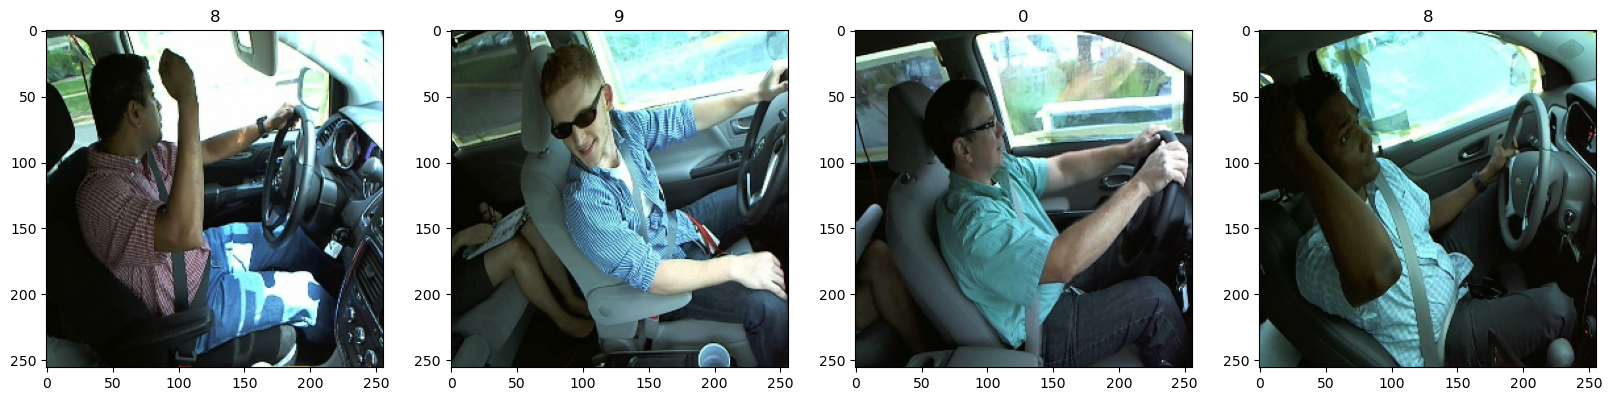

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# Train Test and Validation Data Split

In [13]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.1)+1

In [14]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [15]:
len(train)

490

# Model Architecture

In [16]:
model = Sequential([
    Conv2D(16, (2,2), 1, input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Conv2D(32, (2,2), 1),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation=tf.nn.relu),
    Dense(10, activation=tf.nn.softmax)
])

In [17]:
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 256)               3

In [19]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.99):
      print("\Accuracy is greater than 99% so cancelling training!")
      self.model.stop_training = True

acc_callback = myCallback()

# Model Training

In [21]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback, acc_callback])

Epoch 1/10


2023-04-21 17:52:14.296246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [22424]
	 [[{{node Placeholder/_4}}]]
2023-04-21 17:52:14.296514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [22424]
	 [[{{node Placeholder/_4}}]]


490/490 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.8518

2023-04-21 17:59:09.961759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [22424]
	 [[{{node Placeholder/_4}}]]
2023-04-21 17:59:09.962067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [22424]
	 [[{{node Placeholder/_4}}]]


490/490 [==============================] - 451s 919ms/step - loss: 0.6870 - accuracy: 0.8518 - val_loss: 0.0746 - val_accuracy: 0.9792
Epoch 2/10
490/490 [==============================] - 441s 900ms/step - loss: 0.0281 - accuracy: 0.9929 - val_loss: 0.0480 - val_accuracy: 0.9867


In [22]:
model.save(os.path.join('models', 'distracted_driver.h5'))

In [23]:
hist.history

{'loss': [0.6869866251945496, 0.02810915745794773],
 'accuracy': [0.8517857193946838, 0.9928571581840515],
 'val_loss': [0.07458380609750748, 0.048001453280448914],
 'val_accuracy': [0.9791666865348816, 0.9867021441459656]}

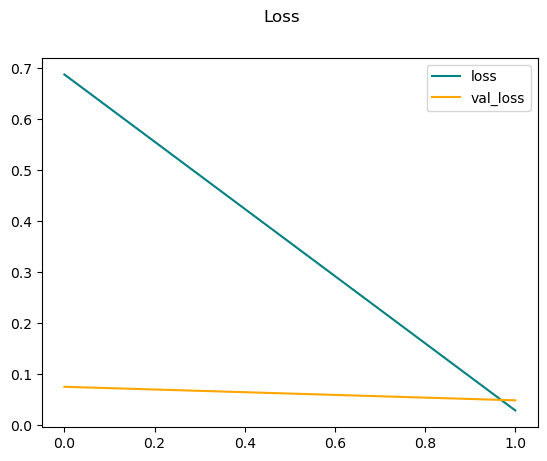

In [24]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss')
plt.legend()
plt.show()

In [25]:
model = load_model(os.path.join("models", "distracted_driver.h5"))

# Model Testing and Performance

In [26]:
correct = 0
total = 0
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    yh = [list(yl) for yl in yhat]
    y1 = [y1.index(max(y1)) for y1 in yh]
    try:
        for i in range(32):
            if y1[i] == y[i]: correct+=1
            total+=1
    except:
        #Done if last batch has less than 32 entries
        print("out of index")

2023-04-21 18:07:22.183355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [22424]
	 [[{{node Placeholder/_0}}]]
2023-04-21 18:07:22.183987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [22424]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 220ms/step
out of index


In [27]:
print("Accuracy is: ", correct/total)

Accuracy is:  0.9852150537634409
